In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)

#import warnings
#warnings.filterwarnings('ignore')

# **FUNCTIONS**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

# list classifiers
lst_algo=['AdaBoost','SVM','KNN','DecisionTreeClassifier','RandomForestClassifier']

#######################################
### test_classifierModels_list function 
#######################################
def test_classifierModels_list(i_classifierModels_list,i_X_train,i_X_test,i_y_train,i_y_test):
  l_dico_name_model={}
  preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))
  RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
  AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
  SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
  KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())
  DTC = make_pipeline(preprocessor, StandardScaler(), DecisionTreeClassifier())
  dict_of_models = {'RandomForestClassifier': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN,
                  'DecisionTreeClassifier':DTC
                 }
  for name, model in dict_of_models.items():
    if name in i_classifierModels_list:
      print('============')
      print(name)
      print('============')
      l_model= fit_and_evaluate_model(model,i_X_train,i_X_test,i_y_train,i_y_test)
      l_dico_name_model[name]=l_model
      #
  return l_dico_name_model

###########################
### Evaluation function 
##########################
# Used to Evaluate models
def fit_and_evaluate_model(i_model,i_X_train,i_X_test,i_y_train,i_y_test, i_use_fit=True,cas_tensorflow=False):
  #
  l_model=i_model
  if not cas_tensorflow:
    if i_use_fit:
      l_model.fit(i_X_train, i_y_train)
  l_ypred = l_model.predict(i_X_test)
  #
  if cas_tensorflow:
    l_ypred_t=np.array([0 for i in range(len(l_ypred))])
    for i in range(len(l_ypred)):
       if l_ypred[i] > 0.5:
         l_ypred_t[i]=1
    l_ypred=l_ypred_t
  #   
  print(confusion_matrix(i_y_test, l_ypred))
  print(classification_report(i_y_test, l_ypred, digits=4))

  return l_model


# list of columns with count of its values by type of columns
def get_value_counts(i_df,i_type):
  lst_nbre_val_col=[]
  cmpt=0
  for col in i_df.select_dtypes(i_type).columns:
    cmpt=i_df[col].value_counts().count()
    lst_nbre_val_col.append((col,cmpt))
  #
  return lst_nbre_val_col
  

#---------------------------------
#--- function show_importances_plot
#---------------------------------
# Only importances > i_threshold
def show_importances_plot(i_model, i_threshold,i_figsize=(11, 6)):
  l_feature_importances_df=pd.DataFrame({'importances': i_model.feature_importances_, 
                                         'columns_': i_model.feature_names_in_})
  l_feature_importances_df.sort_values(by=['importances'], ascending=True, inplace=True)
  feature_importances_df_t=l_feature_importances_df[l_feature_importances_df['importances'] > i_threshold]
  feature_importances_df_t.set_index('columns_',inplace=True)
  #
  feature_importances_df_t.plot(figsize=i_figsize,kind='barh')
  return feature_importances_df_t

# return list of dep columns couple 
def verify_dependency(i_corr_matrix,i_threshold):
  # looking for features corresponding at the threshold 0.35
  cols=i_corr_matrix.columns
  l_tupe_dep=[]  # list tuple of columns to verify dep condition  
  l_cmpt=0
  for col1 in cols:
    for col2 in cols:
      l_val=i_corr_matrix.loc[col2,col1]
      #if l_cmpt < 10:
        #print (abs(l_val))
        #l_cmpt=l_cmpt+1
      if abs(l_val) > i_threshold:
        if col1!=col2:
          if (col1,col2) not in l_tupe_dep:
            l_tupe_dep.append((col1,col2))

  return l_tupe_dep

#---------------------------------
#--- function get_model()
# give model with appropriate input_dim as parameter
#---------------------------------
#
def get_model(i_input_dim,i_regul_l2=0.0001,i_def_mode=1):
  l_model=Sequential()
  if i_def_mode==1:
    l_model.add(Dense(1024, input_dim=i_input_dim,activation='relu',kernel_regularizer=l2(i_regul_l2))) 
    l_model.add(Dropout(0.7))
  #
  if i_def_mode==2:
    l_model.add(Dense(1278, input_dim=i_input_dim,activation='relu',kernel_regularizer=l2(i_regul_l2))) 
    l_model.add(Dropout(0.5))
    l_model.add(Dense(512, activation='elu'),
                      kernel_regularizer=l2(i_regul_l2)),
    l_model.add(Dropout(0.5))                               
  l_model.add(Dense(1,activation='sigmoid'))
  #
  return l_model

# **Preprocessing**

In [5]:
import pandas as pd
df_init = pd.read_csv('/content/loan_data.csv')
#
df=df_init.copy(deep=True)
# Top 5 records
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [7]:
df.columns

Index(['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc',
       'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid'],
      dtype='object')

In [8]:
df.dtypes.value_counts()

int64      7
float64    6
object     1
dtype: int64

In [9]:
df.select_dtypes('object').head()

,purpose
0,debt_consolidation
1,credit_card
2,debt_consolidation
3,debt_consolidation
4,credit_card


In [10]:
df['purpose'].value_counts()

debt_consolidation    3957
all_other             2331
credit_card           1262
home_improvement       629
small_business         619
major_purchase         437
educational            343
Name: purpose, dtype: int64

In [11]:
# type= Object
lst_t=get_value_counts(df,'object')
lst_t

[('purpose', 7)]

In [12]:
# int64
df.select_dtypes('int64').head()

,credit.policy,fico,revol.bal,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,737,28854,0,0,0,0
1,1,707,33623,0,0,0,0
2,1,682,3511,1,0,0,0
3,1,712,33667,1,0,0,0
4,1,667,4740,0,1,0,0


In [13]:
# type= int64
lst_t=get_value_counts(df,'int64')
lst_t

[('credit.policy', 2),
 ('fico', 44),
 ('revol.bal', 7869),
 ('inq.last.6mths', 28),
 ('delinq.2yrs', 11),
 ('pub.rec', 6),
 ('not.fully.paid', 2)]

In [14]:
# float64
df.select_dtypes('float64').head()

,int.rate,installment,log.annual.inc,dti,days.with.cr.line,revol.util
0,0.1189,829.10,11.350407,19.48,5639.958333,52.1
1,0.1071,228.22,11.082143,14.29,2760.000000,76.7
2,0.1357,366.86,10.373491,11.63,4710.000000,25.6
3,0.1008,162.34,11.350407,8.10,2699.958333,73.2
4,0.1426,102.92,11.299732,14.97,4066.000000,39.5


In [15]:
# type= float64
lst_t=get_value_counts(df,'float64')
lst_t

[('int.rate', 249),
 ('installment', 4788),
 ('log.annual.inc', 1987),
 ('dti', 2529),
 ('days.with.cr.line', 2687),
 ('revol.util', 1035)]

In [16]:
df1=pd.get_dummies(df)
df1.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,0,1,0,0,0,0,0


In [17]:
df1.dtypes.value_counts()

int64      7
uint8      7
float64    6
dtype: int64

In [18]:
# reminder
df.dtypes.value_counts()

int64      7
float64    6
object     1
dtype: int64

In [19]:
# uint8
df1.select_dtypes('uint8').columns

Index(['purpose_all_other', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_major_purchase',
       'purpose_small_business'],
      dtype='object')

In [20]:
# type= uint8
lst_t=get_value_counts(df1,'uint8')
lst_t

[('purpose_all_other', 2),
 ('purpose_credit_card', 2),
 ('purpose_debt_consolidation', 2),
 ('purpose_educational', 2),
 ('purpose_home_improvement', 2),
 ('purpose_major_purchase', 2),
 ('purpose_small_business', 2)]

In [21]:
# type= uint8
lst_t=df1.select_dtypes('uint8').values
ll=[]
for i in range(len(lst_t)):
  ll=ll+list(lst_t[i,:])
set(ll)

{0, 1}

In [22]:
# def of X, Y
Y=df1[df1.columns[0]]
X=df1[df1.columns[1:]]
X.shape, Y.shape,len(df1),len(df1.columns)

((9578, 19), (9578,), 9578, 20)

corr_matrix_X.shape
(19, 19)

No dependency: []




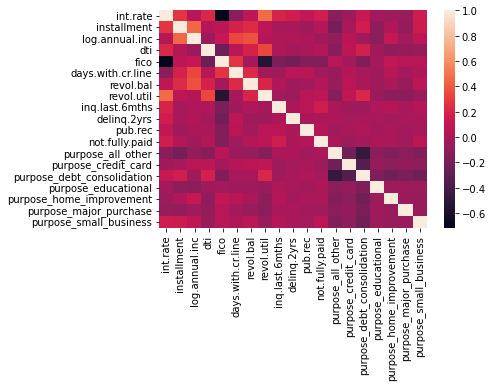

In [23]:
# Significant dependency
corr_matrix_X = X.corr()
print('corr_matrix_X.shape')
print(corr_matrix_X.shape)
#
coef_dep=0.85
#
if len(verify_dependency(corr_matrix_X,coef_dep))==0:
  print('\nNo dependency:', verify_dependency(corr_matrix_X,coef_dep))
else:
  print('\nDependency:....', verify_dependency(corr_matrix_X,coef_dep))  
#
print('\n')
import seaborn as sns
sns.heatmap(corr_matrix_X)

In [24]:
# Split() ---> define X_train,X_test,y_train,y_test
from sklearn.model_selection import train_test_split
#
in_test_size=25/100
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=in_test_size,random_state=0)
#
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((7183, 19), (2395, 19), (7183,), (2395,))

In [25]:
# list classifiers
import warnings
warnings.filterwarnings('ignore')

lst_algo=['AdaBoost','SVM','KNN','DecisionTreeClassifier','RandomForestClassifier']
#
dico_name_model=test_classifierModels_list(lst_algo,X_train,X_test,y_train,y_test)
#dico_name_model


RandomForestClassifier
[[ 399   80]
 [   2 1914]]
              precision    recall  f1-score   support

           0     0.9950    0.8330    0.9068       479
           1     0.9599    0.9990    0.9790      1916

    accuracy                         0.9658      2395
   macro avg     0.9774    0.9160    0.9429      2395
weighted avg     0.9669    0.9658    0.9646      2395

AdaBoost
[[ 364  115]
 [  17 1899]]
              precision    recall  f1-score   support

           0     0.9554    0.7599    0.8465       479
           1     0.9429    0.9911    0.9664      1916

    accuracy                         0.9449      2395
   macro avg     0.9491    0.8755    0.9065      2395
weighted avg     0.9454    0.9449    0.9424      2395

SVM
[[ 324  155]
 [   8 1908]]
              precision    recall  f1-score   support

           0     0.9759    0.6764    0.7990       479
           1     0.9249    0.9958    0.9590      1916

    accuracy                         0.9319      2395
   macro av

In [26]:
model_rfc = RandomForestClassifier(random_state=10)
model_rfc_fit= fit_and_evaluate_model(model_rfc,X_train,X_test,y_train,y_test)

[[ 461   18]
 [   7 1909]]
              precision    recall  f1-score   support

           0     0.9850    0.9624    0.9736       479
           1     0.9907    0.9963    0.9935      1916

    accuracy                         0.9896      2395
   macro avg     0.9879    0.9794    0.9835      2395
weighted avg     0.9895    0.9896    0.9895      2395



In [27]:
model_rfc = RandomForestClassifier(random_state=10)
model_rfc_fit= model_rfc.fit(X_train,y_train)
model_rfc_fit.score(X_test,y_test)

0.9895615866388309

In [35]:
min=2
idx=0
for i in range(11):
  model_rfc = RandomForestClassifier(random_state=i)
  model_rfc_fit= model_rfc.fit(X_train,y_train)
  if model_rfc_fit.score(X_test,y_test) < min:
    min=model_rfc_fit.score(X_test,y_test)
    idx=i
idx,min

(10, 0.9895615866388309)

5

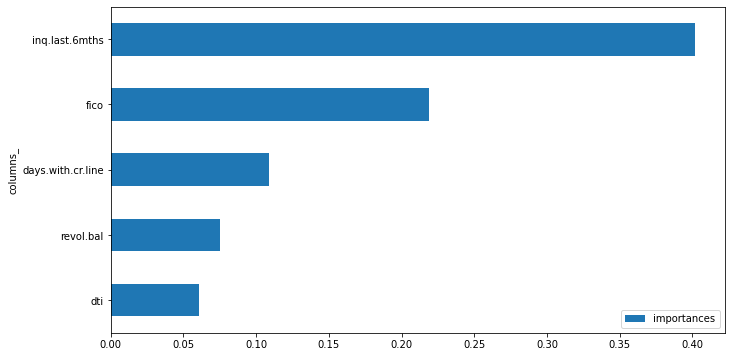

In [30]:
#--------------------------------------------
#--- feature_importances ---> for RandomForestClassifier 
#-------------------------------------------
#
feature_importances_rfc=show_importances_plot(model_rfc_fit,i_threshold=0.05) #0.01
len(feature_importances_rfc)


In [31]:
#columns list
list(feature_importances_rfc.index)

['dti', 'revol.bal', 'days.with.cr.line', 'fico', 'inq.last.6mths']

In [32]:
list_rest_cols=list(feature_importances_rfc.index)
#
X_train1=X_train[list_rest_cols]
X_test1=X_test[list_rest_cols]
y_train1=y_train
y_test1=y_test

#
model_rfc_fit1= fit_and_evaluate_model(model_rfc,X_train1,X_test1,y_train1,y_test1)

#dico_model_ros2 = test_classifierModels_list(classifierModels_dict, X_train_ros[list_rest_cols],X_test[list_rest_cols],y_train,y_test,False)

[[ 458   21]
 [   3 1913]]
              precision    recall  f1-score   support

           0     0.9935    0.9562    0.9745       479
           1     0.9891    0.9984    0.9938      1916

    accuracy                         0.9900      2395
   macro avg     0.9913    0.9773    0.9841      2395
weighted avg     0.9900    0.9900    0.9899      2395



In [33]:
list_rest_cols=list(feature_importances_rfc.index)
#
X_train1=X_train[list_rest_cols]
X_test1=X_test[list_rest_cols]
y_train1=y_train
y_test1=y_test
#
print('X_train1.shape,y_train1.shape,X_test1.shape,y_test1.shape')
print(X_train1.shape,y_train1.shape,X_test1.shape,y_test1.shape)
#
model_rfc = RandomForestClassifier(random_state=10)
model_rfc_fit1= model_rfc.fit(X_train1,y_train1)
score=model_rfc_fit1.score(X_test1,y_test1)
print('\n--------')
print('Accuracy=',score)
print('--------')

X_train1.shape,y_train1.shape,X_test1.shape,y_test1.shape
(7183, 5) (7183,) (2395, 5) (2395,)

--------
Accuracy= 0.9899791231732776
--------


corr_matrix.shape
(5, 5)

No dependency: []




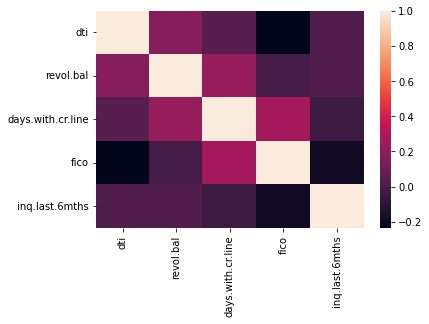

In [34]:
# Create correlation matrix
corr_matrix = X_train1.corr()
print('corr_matrix.shape')
print(corr_matrix.shape)
#
coef_dep=0.35 # 0.85
#
if len(verify_dependency(corr_matrix,coef_dep))==0:
  print('\nNo dependency:', verify_dependency(corr_matrix,coef_dep))
else:
  print('\nDependency:....', verify_dependency(corr_matrix,coef_dep))  
#
print('\n')
import seaborn as sns
sns.heatmap(corr_matrix)

# **BUILD**

In [36]:
# backend keras = ? tensorflow 
import keras
keras.backend.backend()

'tensorflow'

In [ ]:
'''
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train2)
#
X_train2 = scaler.transform(X_train2)
X_test2 = scaler.transform(X_test2)
'''

In [37]:
# X_train1,X_test1,y_train1,y_test1
X_train2=X_train1.copy(deep=True)
X_test2=X_test1.copy(deep=True)
y_train2=y_train1.copy(deep=True)
y_test2=y_test1.copy(deep=True)
#
scaler2=StandardScaler()
scaler2.fit(X_train2)
#
X_train2 = scaler2.transform(X_train2)
X_test2 = scaler2.transform(X_test2)

In [38]:
# Callback
class myCallback(tf.keras.callbacks.Callback):
  max_val_Acc=0

  def __init__(self,i_threshold):
    self.threshold_cb=i_threshold
  
  def on_epoch_end(self, epoch, logs={}):
      if (logs.get('val_accuracy') > self.threshold_cb): 
          print("\nReached ", self.threshold_cb*100 ,
                "% val_accuracy so cancelling training!")
          print("\nepoch: ", epoch)
          print('Acc=', logs.get('accuracy'))
          print('val_Acc=', logs.get('val_accuracy'))
          print('loss=', logs.get('loss'))
          print('\n')
          self.model.stop_training = True
      if (epoch%1000==0):
        print("\nepoch: ", epoch)
        print('Acc=', logs.get('accuracy'))
        print('val_Acc=', logs.get('val_accuracy'))
        if logs.get('val_accuracy') > self.max_val_Acc:
          self.max_val_Acc= logs.get('val_accuracy')
        print('max_val_Acc=', self.max_val_Acc)
        print('loss=', logs.get('loss'))

In [39]:
# Building model preparation
#N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 1024
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

# InverseTimeDecay
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*300, # 1000
  decay_rate=1,
  staircase=False)

# optimizer
def get_optimizer(i_lr_schedule):
  l_adam= tf.keras.optimizers.Adam (
      learning_rate=i_lr_schedule,
      beta_1=0.9,
      name='adam' 
  )
  return l_adam

In [ ]:
###############################################
### --- Building model
###############################################
target_score=0.98
callbacks = myCallback(target_score)

model_tf = get_model(X_train2.shape[1],i_def_mode=1)

model_tf.compile(loss='binary_crossentropy', optimizer=get_optimizer(lr_schedule),
              metrics=['accuracy']) 

import time
start=time.time()

history=model_tf.fit(X_train2,y_train2,epochs=50000,batch_size=BATCH_SIZE,  
                  validation_data=(X_test2, y_test2) ,callbacks=[callbacks],verbose=0)

end=time.time()
print('running time: ',end-start)

score=model_tf.evaluate(X_test2,y_test2,batch_size=BATCH_SIZE)

print('\nscore: ',score,'\n')


epoch:  0
Acc= 0.6749269366264343
val_Acc= 0.8592901825904846
max_val_Acc= 0.8592901825904846
loss= 0.6492795944213867

epoch:  1000
Acc= 0.9618543982505798
val_Acc= 0.9649269580841064
max_val_Acc= 0.9649269580841064
loss= 0.12506437301635742

epoch:  2000
Acc= 0.9661701321601868
val_Acc= 0.9736952185630798
max_val_Acc= 0.9736952185630798
loss= 0.11430052667856216

epoch:  3000
Acc= 0.9704858660697937
val_Acc= 0.9757828712463379
max_val_Acc= 0.9757828712463379
loss= 0.10679269582033157

epoch:  4000
Acc= 0.9700682163238525
val_Acc= 0.9774530529975891
max_val_Acc= 0.9774530529975891
loss= 0.10118568688631058

epoch:  5000
Acc= 0.9722957015037537
val_Acc= 0.9774530529975891
max_val_Acc= 0.9774530529975891
loss= 0.09867680817842484

Reached  98.0 % val_accuracy so cancelling training!

epoch:  5939
Acc= 0.973827064037323
val_Acc= 0.9803757667541504
loss= 0.09569501876831055


running time:  1048.621102809906
3/3 [==============================] - 0s 7ms/step - loss: 0.1025 - accuracy: 0.

In [ ]:
print('score: ',score,'\n')
model= fit_and_evaluate_model(model_tf,X_train2,X_test2,y_train2,y_test2,i_use_fit=False,cas_tensorflow=True)

score:  [0.10246644914150238, 0.9803757667541504] 

[[ 447   32]
 [  15 1901]]
              precision    recall  f1-score   support

           0     0.9675    0.9332    0.9501       479
           1     0.9834    0.9922    0.9878      1916

    accuracy                         0.9804      2395
   macro avg     0.9755    0.9627    0.9689      2395
weighted avg     0.9803    0.9804    0.9802      2395



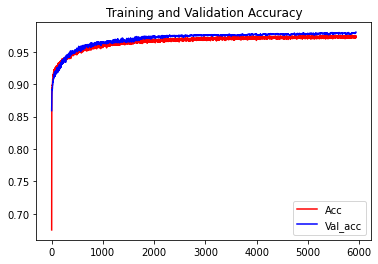

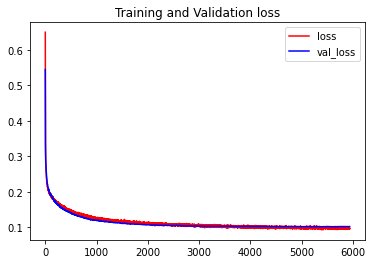

In [ ]:
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
#
plt.title('Training and Validation Accuracy')
plt.legend(['Acc','Val_acc'])
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs
#
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
#
plt.title('Training and Validation loss')
plt.legend(['loss','val_loss'])
plt.show()
print("")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.save_weights('/content/drive/MyDrive/---TMP/aa_models/weights/')

In [ ]:
model.save(filepath='/content/drive/MyDrive/---TMP/aa_models/model.h5')

In [ ]:
model.save(filepath='/content/drive/MyDrive/---TMP/aa_models/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/---TMP/aa_models/assets


In [ ]:
model2=tf.keras.models.load_model('/content/drive/MyDrive/---TMP/aa_models/model.h5')
# Checking
score2=model2.evaluate(X_test2,y_test2,batch_size=BATCH_SIZE)
print('\nscore2: ',score2,'\n')

3/3 [==============================] - 0s 11ms/step - loss: 0.1022 - accuracy: 0.9804

score2:  [0.10222778469324112, 0.9803757667541504] 



In [ ]:
# continue to fit() model
seuil=0.985
callbacks2 = myCallback2(seuil)
history=model2.fit(X_train2,y_train2,epochs=50000,batch_size=BATCH_SIZE,  validation_data=(X_test2, y_test2) ,callbacks=[callbacks2],verbose=0)
score=model.evaluate(X_test2,y_test2,batch_size=BATCH_SIZE)
print('\nscore: ',score,'\n')

In [ ]:
print('score: ',score,'\n')
model= fit_and_evaluate_model(model,X_train2,X_test2,y_train2,y_test2,i_use_fit=False,cas_tensorflow=True)

score:  [0.127444326877594, 0.9895615577697754, 0.9893317222595215] 

[[ 459   20]
 [   5 1911]]
              precision    recall  f1-score   support

           0     0.9892    0.9582    0.9735       479
           1     0.9896    0.9974    0.9935      1916

    accuracy                         0.9896      2395
   macro avg     0.9894    0.9778    0.9835      2395
weighted avg     0.9896    0.9896    0.9895      2395



In [40]:
from xgboost import XGBClassifier
from xgboost import plot_importance
model_xgb = XGBClassifier(random_state=10) # random_state=10
model_xgb_fit= fit_and_evaluate_model(model_xgb,X_train,X_test,y_train,y_test)

[[ 463   16]
 [   2 1914]]
              precision    recall  f1-score   support

           0     0.9957    0.9666    0.9809       479
           1     0.9917    0.9990    0.9953      1916

    accuracy                         0.9925      2395
   macro avg     0.9937    0.9828    0.9881      2395
weighted avg     0.9925    0.9925    0.9924      2395



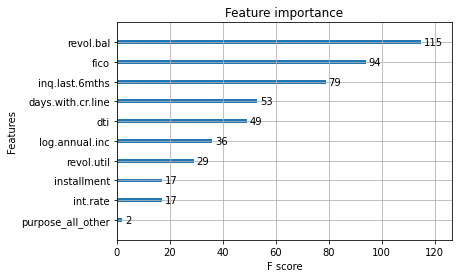

In [41]:
# plot feature importance
plot_importance(model_xgb_fit)
plt.show()

In [ ]:
###################################
#--- Selecting of optimizer
###################################
#
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(optimizer='RMSprop',learn_rate=0.001,momentum=0):
  # create model
  model = get_model(5)
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.95):
        #if (logs.get('auc') > 0.95):
            print("\nReached 99.8% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()


# split into input (X) and output (Y) variables
X = X_train2
Y = y_train2
# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=256, verbose=2)  #batch_size=10
# define the grid search parameters
optimizer = ['Adadelta', 'Adam', 'RMSprop']  # ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'] 
learn_rate = [0.001]   # [0.001, 0.01, 0.1]
momentum = [0.4, 0.6, 0.9]   #
param_grid = dict(optimizer=optimizer,learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2,verbose=2)
grid_result = grid.fit(X, Y, callbacks=[callbacks],verbose=2)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
#============================================ FIN =============================================================

# TMP

In [ ]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier
def create_model(optimizer='RMSprop',learn_rate=0.01, momentum=0):
  # create model
  model = Sequential()
  model.add(Dense(512, input_dim=5, activation='relu'))
  model.add(Dropout(0.6))
  model.add(Dense(512, input_dim=5, activation='relu'))
  model.add(Dropout(0.6))
  model.add(Dense(1, activation='sigmoid'))
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.94):
        #if (logs.get('auc') > 0.95):
            print("\nReached 99.8% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()


# split into input (X) and output (Y) variables
X = X_train1
Y = y_train1
# create model
model = KerasClassifier(build_fn=create_model, epochs=500, batch_size=10, verbose=2)
# define the grid search parameters
optimizer = ['Adadelta']# ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'] 
learn_rate = [0.001, 0.01, 0.1]
momentum = [0.4, 0.6, 0.9]   #
param_grid = dict(optimizer=optimizer,learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2,verbose=2)
grid_result = grid.fit(X, Y, callbacks=[callbacks],verbose=2)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
param_grid
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

In [ ]:
import tensorflow as tf

tf.debugging.set_log_device_placement(True)

# Place tensors on the CPU
with tf.device('/CPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

# Run on the GPU
c = tf.matmul(a, b)
print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB


In [ ]:
import cv2
import numpy as np

# Load Yolo
net = cv2.dnn.readNet("/content/yolov3.weights", "/content/yolov3.cfg")
classes = []
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
print(output_layers)
colors = np.random.uniform(0, 255, size=(len(classes), 3))


['yolo_82', 'yolo_94', 'yolo_106']


In [ ]:
import cv2
import numpy as np

#___________________________________________________________________________

# Load Yolo
net = cv2.dnn.readNet("/content/yolov3.weights", "/content/yolov3.cfg")
classes = []
with open("/content/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))
#_______________________________________________________________________

#Image to be loaded and use
img = cv2.imread("images/living_room.jpg")
cv2.imshow ("Image", img)

cv2.waitKey(0)
cv2.destroyAllWindows()
#_______________________________________________________________________

img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape

#______________________________________________________________________

# Detecting objects
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)
print (outs)

#__________________________________________________________________________

# Showing informations on the screen
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)
#_____________________________________________________________________________
cv2.rectangle(img, (x,y),(x+w,y+h),(0,255,0),2)
cv2.imshow("Image",img)

#___________________________________________________________________________
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

#___________________________________________________________________________


font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[i]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y + 30), font, 3, color, 3)


cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
